# Data Challenge 1: Employee Retention

## Load Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno

In [2]:
#add path to my Dropbox 
#get path to my dropbox directory, assuming jq is install
s = !jq -r ".personal.path" < ~/.dropbox/info.json 
print("path to dropbox: ", s)
import sys
sys.path.insert(0, s[0])
from pytools import data_tools

path to dropbox:  ['/home/marcel/Dropbox']


## Load The Data

In [3]:
employee = pd.read_csv('data/employee_retention_data.csv')
df = employee.copy()

## Shape of Data

In [4]:
print("Number of sample = {} and number of features = {}".format(df.shape[0], df.shape[1])) 

Number of sample = 24702 and number of features = 7


## Check Data Types

In [5]:
df.dtypes

employee_id    float64
company_id       int64
dept            object
seniority        int64
salary         float64
join_date       object
quit_date       object
dtype: object

**Note:**  
- **Employee_Id** is currently type float but should be int 
- **join_date** and **quit_date** are currently objects, but should be datetime

## Convert data types to appropriate types

In [6]:
df.join_date = pd.to_datetime(df.join_date)
df.quit_date = pd.to_datetime(df.quit_date)
df.employee_id = df.employee_id.astype(int)
df.company_id = df.company_id.astype('object')
df.dtypes

employee_id             int64
company_id             object
dept                   object
seniority               int64
salary                float64
join_date      datetime64[ns]
quit_date      datetime64[ns]
dtype: object

In [7]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315,4,marketing,14,101000.0,2014-10-13,NaT
3,662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971,2,data_science,23,276000.0,2011-10-17,2014-08-22


## Missing Values

In [8]:
df.isnull().sum()

employee_id        0
company_id         0
dept               0
seniority          0
salary             0
join_date          0
quit_date      11192
dtype: int64

## Summary 

In [9]:
df.describe()

,employee_id,seniority,salary
count,24702.000000,24702.000000,24702.000000
mean,501604.403530,14.127803,138183.345478
std,288909.026101,8.089520,76058.184573
min,36.000000,1.000000,17000.000000
25%,250133.750000,7.000000,79000.000000
50%,500793.000000,14.000000,123000.000000
75%,753137.250000,21.000000,187000.000000
max,999969.000000,99.000000,408000.000000


We see there is an employee who has worked for 99 years (**seniority**). This does not seem right. Investigate further (there is another with seniority = 98)

In [10]:
print(df.seniority.unique())
df[(df.seniority == 98) | (df.seniority == 99)]

[28 20 14 23 21  4  7 13 17  1 10  6 19 15 26 27  5 18 16 25  9  2 29  3
  8 22 24 12 11 98 99]


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
24700,97289,10,engineer,98,266000.0,2011-12-13,2015-01-09
24701,604052,1,marketing,99,185000.0,2011-07-26,2013-12-06


In [11]:
#replace 98 and 99 with 29, the most reasonable highest value
df.loc[24700, 'seniority'] = 29
df.loc[24701, 'seniority'] = 29

## Make sure there is only one entry per employee

In [12]:
assert(len(df.employee_id.unique()) == df.shape[0])

Given that there is only one entry per employee, employee_id has no predictive value here. We can use it as index for the dataframe. This also means, we can't track employee salary in time, hence will not be able to know if an amployee quitted because their salary remained constant for a long time

## Create a boolean column for quited

In [13]:
# quited = 0 if quit_date missing else 1
quit_mask = df.quit_date.isnull() == False
df['quited'] = quit_mask.apply(int)
df = df.set_index('employee_id', drop=True)
df.head(4)

,company_id,dept,seniority,salary,join_date,quit_date,quited
employee_id,,,,,,,
13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1
825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,1
927315,4,marketing,14,101000.0,2014-10-13,NaT,0
662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1


## Print some general infos about dataframe 

In [14]:
data_tools.print_infos(df)

Dataframe dimensions: (24702, 7)
                company_id    dept seniority   salary       join_date  \
column type         object  object     int64  float64  datetime64[ns]   
Null values              0       0         0        0               0   
Null values (%)          0       0         0        0               0   
Number unique           12       6        29      367             995   

                      quit_date quited  
column type      datetime64[ns]  int64  
Null values               11192      0  
Null values (%)         45.3081      0  
Number unique               664      2  


## Class Proportions

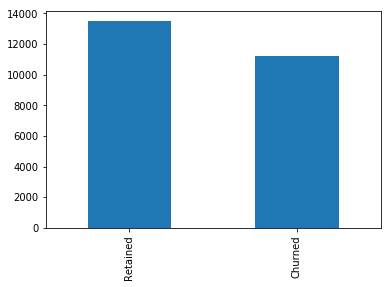

In [15]:
def plot_class_proportion(labels):
    
    ratio = labels.value_counts()
    ratio.index = ['Retained', 'Churned']
    ratio.plot(kind='bar')
    #plt.savefig('figures/class_proportions.png')
plot_class_proportion(df.quited)

# Data Exploration

In [16]:
#helper function to perform ztest of proportions
def ztest(df, column, group1, group2):
    """
    perform ztest for two groups.
    df    : the dataframe
    column: the column we are interested in
    group1: one of the categories in the column
    group2: another category
    """ 
    import statsmodels.api as sm
    
    #count the number of positive instance in group1
    p0 = len(df[(df[column] == group1) & (df.quited == 1)])
    #total number oof instances in group1
    n0 = len(df[(df[column] == group1)])
    
    p1 = len(df[(df[column] == group2) & (df.quited == 1)])
    n1 = len(df[(df[column] == group2)])
    
    z_score, p_value = sm.stats.proportions_ztest(count=[p0, p1], nobs=[n0, n1])
    return z_score, p_value

def proportion_ztest(df, column, alpha=0.05):
    """
    performs independent ztests on all pairs of groups
    """
    import statsmodels.api as sm
    
    options = list(df[column].unique())
    insignificant = []
    significant = []
    
    #find unique pairs
    pairs = []
    for i in range(0, len(options)):
        for j in range(i+1, len(options)):
            pairs.append((options[i], options[j])) 
    
    for pair in pairs:
        z_score, p_value = ztest(df, column, pair[0], pair[1])
        if p_value < alpha: #reject H_0
            insignificant.append((pair, p_value))
        else:
            significant.append((pair, p_value))
    return insignificant, significant

### Correlation between target and company_id

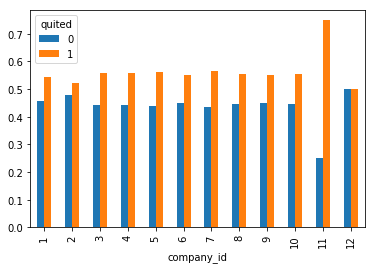

In [17]:
#plt.rcParams.update({'font.size': 12})
_ = pd.crosstab(df.company_id, df.quited, normalize=0).plot(kind='bar')

In [18]:
insignificant, significant = proportion_ztest(df, 'company_id')
insignificant

[((7, 2), 0.008147216455192572),
 ((4, 2), 0.006220849169380669),
 ((2, 1), 0.018908302229472415),
 ((2, 5), 0.007939968967133589),
 ((2, 3), 0.00484793319183257)]

- Visually, all companies have similar retention rates, except company 11
- Company 12 seems to have almost equal ratio of employee who quitted and those who are still present
- Maybe then **company_id** can be transformed into 3 categories instead of 12
    - one category for company 11
    - one category for company 12
    - one category for all the rest (since they all look similar in terms of relation to target)
- **ztest** suggests that only company 2 might have a significant difference from others in terms of churn proportion
- Maybe have only two categories, one for company 2 and one for others 

### Correlation between target and department

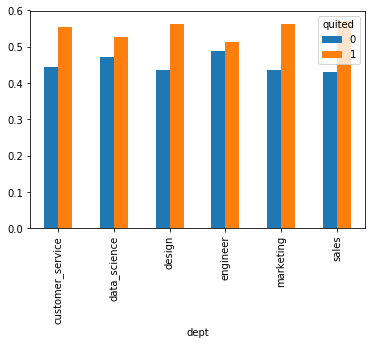

In [19]:
_ = pd.crosstab(df.dept, df.quited, normalize=0).plot(kind='bar')

## Loking at Salary vs Seniority 

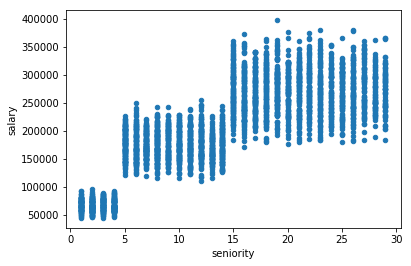

In [20]:
_ = df[df.dept=='data_science'].plot(x='seniority', y='salary', kind='scatter')

**Note:**  

It appears that salary increase is incremental with 3 chuck   
- 1-5 years fall in thesame seniority category
- 5-15 years
- 15 years and above

### Perform ztest of proportion to see if the difference between departments is significant

In [21]:
insignificant, significant = proportion_ztest(df, 'dept')
insignificant

[(('customer_service', 'data_science'), 0.006913411144791306),
 (('customer_service', 'engineer'), 1.8736125427555084e-06),
 (('marketing', 'data_science'), 0.004240992230664227),
 (('marketing', 'engineer'), 9.587221589710114e-06),
 (('data_science', 'sales'), 0.0004664658059825876),
 (('data_science', 'design'), 0.023082128137744837),
 (('engineer', 'sales'), 3.0459598924820376e-07),
 (('engineer', 'design'), 0.000734738428378415)]

<hr>  

**Note:**   

- The feature **dept** has 5 categories, but can be grouped into 2 main categories according to how the proportions of people who quitted varies between the categories   
- **engineer** and **data_science** employee seem to fall in one category  
- **customer_service**, **sales**, and **design** can be grouped into one category  

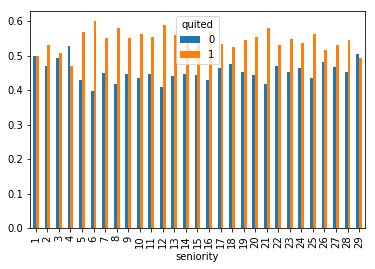

In [22]:
_ = pd.crosstab(df.seniority, df.quited, normalize=0).plot(kind='bar')

In [23]:
#insignificant, significant = proportion_ztest(df, 'seniority')
#len(insignificant)

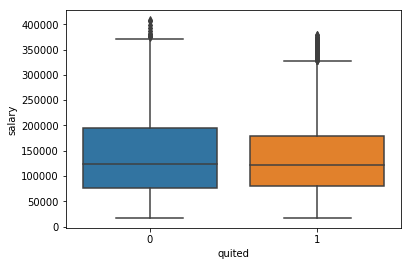

In [24]:
import seaborn as sns
_ = sns.boxplot(x='quited', y='salary', data=df)

In [25]:
import statsmodels
import scipy

x1 = df[df.quited == 1]['salary']
x2 = df[df.quited == 0]['salary']
print("Test of Normality", scipy.stats.normaltest(x1))

statsmodels.stats.weightstats.ztest(x1, x2)

Test of Normality NormaltestResult(statistic=957.1125738370777, pvalue=1.4643514148823831e-208)


(-5.7498619463708875, 8.93163494288991e-09)

**Note:**  
The test of normality shows that the samples from employees who churned and those who are still present do not follow a normal distribution, so the ztest for means is not even appropriate here. 

# Modeling

In [26]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVR, SVR, LinearSVC
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_recall_curve, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Imputer, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

from mlencoders.weight_of_evidence_encoder import WeightOfEvidenceEncoder
from mlencoders.target_encoder import TargetEncoder
import warnings
warnings.filterwarnings("ignore") 


def count_months(join_date, quit_date):
    """
    compute the number of months between join_date and quit_date
    input: join_date, quit_date - series
    return: list, number of months if employee quited 
           assume 30 years for missing quit date (employee still around)
    """
    
    from dateutil.relativedelta import relativedelta
    delta = []
    for d1, d2 in zip(join_date, quit_date):
        if pd.isnull(d2):
            #employee still present, assume 30 * 12 months of service
            delta.append(30*12)
        else:
            #employee quited, caculate number of months
            time_dif = relativedelta(d2, d1)
            delta.append(time_dif.years*12+time_dif.months)
            
    return delta

class DataFrameSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.attribute_names].values
    
class AttributeAdder(BaseEstimator, TransformerMixin):
    
    def __init__(self, attribute_names=None):
        self.attribute_names = attribute_names
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        group = ['tech_yes' if value in ['data_science', 'engineer'] else 'tech_no' for value in X['dept']]
        company = ['company_id_2' if value == 2 else 'company_id_others' for value in X['company_id']]
        X['technical'] = group 
        X['company_2'] = company 
        
        #date components
        X['join_year'] = X['join_date'].dt.year
        X['join_month'] = X['join_date'].dt.month
        X['join_day'] = X['join_date'].dt.day
        X['total_months'] = count_months(X['join_date'], X['quit_date'])
        
        stats = X.groupby('dept')['salary'].agg(['mean', 'max', 'min'])
        stats.columns = ['mean_salary_dept', 'max_salary_dept', 'min_salary_dept']

        # Merge with the clients dataframe
        X = X.merge(stats, left_on = 'dept', right_index=True, how = 'left')
      
        return X
    
    
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# Feature Engineering

Engineer new features:
- **technical :** whether the employee is from a technical department or not
- **company_2 :** whether the company has company_id = 2
- **join_year**, **join_month**, **join_day**  
- **mean_salary_dept:** the average salary per department
- **max_salary_dept:** the maximum salary per department
- **min_salary_dept:** the minimum salary per department
- **total_month** this is a target variable to predict 

In [27]:
adder = AttributeAdder()
df = adder.fit_transform(df); df[df.columns[7:]].head()

,technical,company_2,join_year,join_month,join_day,total_months,mean_salary_dept,max_salary_dept,min_salary_dept
employee_id,,,,,,,,,
13021,tech_no,company_id_others,2014,3,24,19,82245.424837,166000.0,17000.0
825355,tech_no,company_id_others,2013,4,29,11,135598.042311,262000.0,30000.0
927315,tech_no,company_id_others,2014,10,13,360,135598.042311,262000.0,30000.0
662910,tech_no,company_id_others,2012,5,14,12,82245.424837,166000.0,17000.0
256971,tech_yes,company_id_2,2011,10,17,34,206885.893417,398000.0,44000.0


# Create Pipelines

In [28]:
targets = ['total_months', 'quited']
num_attribs, cat_attribs, date_attribs = data_tools.getColumnDataTypes(df.drop(targets, axis=1))
#num_attribs = ['join_year', 'salary', 'join_day', 'seniority', 'join_month']
#cat_attribs = ['company_id', 'dept']
def make_numeric_pipeline(attribs):
    num_pipeline = Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('scaler', StandardScaler()),
    ])
    return num_pipeline

def make_categoric_pipeline(attribs):
    cat_pipeline = Pipeline([
        ('selector', DataFrameSelector(attribs)),
        ('encoder', OneHotEncoder(sparse=False)),
        #('encoder', TargetEncoder()),
    ])
    return cat_pipeline


def make_pipeline(num_attribs, cat_attribs):
    
    num_pipeline = make_numeric_pipeline(num_attribs)
    cat_pipeline = make_categoric_pipeline(cat_attribs)

    full_pipeline = FeatureUnion(
        transformer_list=[
            ('num_pipeline', num_pipeline),
            ('cat_pipeline', cat_pipeline),
        ])
    return full_pipeline, num_pipeline, cat_pipeline

full_pipeline, num_pipeline, cat_pipeline = make_pipeline(num_attribs, cat_attribs)

print("Numeric attributes:\n", num_attribs)
print("\nCategorical attributes:\n", cat_attribs)

Numeric attributes:
 ['seniority', 'salary', 'join_year', 'join_month', 'join_day', 'mean_salary_dept', 'max_salary_dept', 'min_salary_dept']

Categorical attributes:
 ['company_id', 'dept', 'technical', 'company_2']


In [29]:
#encoder = MultiColumnLabelEncoder(columns = ['dept'])
y = df.quited
X = df[num_attribs+cat_attribs]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train_encoded = full_pipeline.fit_transform(X_train, y_train)
X_test_encoded = full_pipeline.transform(X_test)

0.5474419310763625

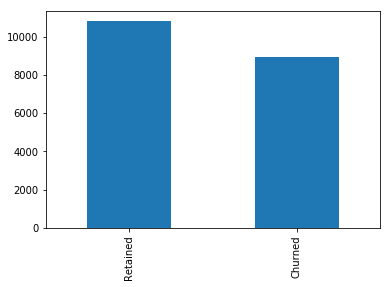

In [30]:
plot_class_proportion(y_train)
sum(y_train)/len(y_train)

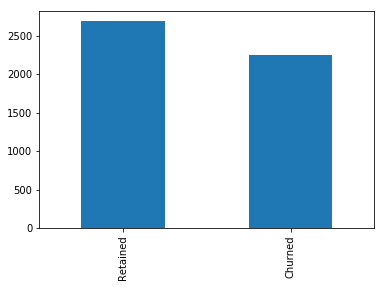

In [31]:
plot_class_proportion(y_test)

In [32]:
#https://github.com/scikit-learn/scikit-learn/issues/10786
from sklearn.utils import check_X_y

model = DummyClassifier(random_state = 0, strategy='most_frequent')
X_converted, y_converted = \
                 check_X_y(X=X_train_encoded, y=y_train)
model.fit(X=X_converted, y=y_converted)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test set:", accuracy)

Accuracy on test set: 0.5448289819874519


## Use Random Forest to Select Subset of Important Features

In [33]:
model = RandomForestClassifier(random_state = 0, 
                               max_features = 'auto',
                               max_depth = 11,
                               min_samples_split= 6, 
                               n_estimators = 100,
                              )

model.fit(X_train_encoded, y_train)

predictions = model.predict(X_test_encoded)
pred_train = model.predict(X_train_encoded)
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, predictions)
print("Accuracy Score Train = ", accuracy_train)
print("Accuracy Score Test = ", accuracy_test)

Accuracy Score Train =  0.8162542381458429
Accuracy Score Test =  0.8002428658166363


In [34]:
cat_encoder = cat_pipeline.named_steps['encoder']

cat_cols = [] 
#get feature names 
for i in range(len(cat_encoder.categories_)):
    cat_cols += list(cat_encoder.categories_[i])

attributes = num_attribs + cat_cols
importance = model.feature_importances_
sorted(zip(importance, attributes), reverse=True)

[(0.7716480966306136, 'join_year'),
 (0.06067520024081901, 'salary'),
 (0.04169078623991721, 'join_day'),
 (0.038951856855991736, 'seniority'),
 (0.03818807844766044, 'join_month'),
 (0.004284021002916861, 'max_salary_dept'),
 (0.004211068192215684, 'mean_salary_dept'),
 (0.0032673897445408416, 1),
 (0.0032567114344587405, 'min_salary_dept'),
 (0.0028364438676070063, 3),
 (0.002700462994969473, 5),
 (0.0025153628948011964, 8),
 (0.0025073847568369266, 4),
 (0.002382772123187257, 9),
 (0.00232771562740959, 6),
 (0.0020268442121725975, 2),
 (0.002008411132209193, 10),
 (0.0020015006784852418, 7),
 (0.0018265837614271593, 'company_id_others'),
 (0.001695154488216629, 'company_id_2'),
 (0.0012953108317096643, 'marketing'),
 (0.001282831161356929, 'engineer'),
 (0.0012283259609048767, 'sales'),
 (0.0010960170751523571, 'design'),
 (0.0010221731439846564, 'tech_yes'),
 (0.0008853800736976744, 'customer_service'),
 (0.0008586292635060603, 'data_science'),
 (0.0007827737826581095, 'tech_no'),


**Note:**  

It looks like the most relevant features are 
- **join_year**
- **salary** 
- **join_day**
- **seniority**
- **join_month**

We can ignore the other features for the rest of the analysis

## How Does Logistic Regression Perform?

In [35]:
num_attribs = ['join_year', 'salary', 'join_day', 'seniority', 'join_month']
cat_attribs = ['dept']
full_pipeline, num_pipeline, cat_pipeline = make_pipeline(num_attribs, cat_attribs)

y = df.quited
X = df[num_attribs+cat_attribs]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)
X_train_encoded = full_pipeline.fit_transform(X_train, y_train)
X_test_encoded = full_pipeline.transform(X_test)


model = LogisticRegression()
model.fit(X_train_encoded, y_train)

predictions = model.predict(X_test_encoded)
pred_train = model.predict(X_train_encoded)
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, predictions)
print("Accuracy Score Train = ", accuracy_train)
print("Accuracy Score Test = ", accuracy_test)

Accuracy Score Train =  0.7921157836141896
Accuracy Score Test =  0.7980165958308035


## How About Support Vector Classifier?

In [36]:
model = LinearSVC(C=0.1)
model = SVC(kernel='rbf', gamma=0.1, C=0.5)
model.fit(X_train_encoded, y_train)

predictions = model.predict(X_test_encoded)
pred_train = model.predict(X_train_encoded)
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, predictions)
print("Accuracy Score Train = ", accuracy_train)
print("Accuracy Score Test = ", accuracy_test)

Accuracy Score Train =  0.7952532766560396
Accuracy Score Test =  0.7972070431086824


## Compare a few Classifiers

In [37]:
def get_cross_validation_scores(X, y, classifiers):
    """
    create a boxplot of cross validation scores to
    visualize how different classifiers perform with 
    default parameters. Assumes all classifiers have been imported
    
    args:
        X -> numpy array, data to fit
        y -> class labels
        classifiers -> list of classifiers names (as strings)
        
    """
    
    cv_scores = {}
    train_scores = {}
    for name in classifiers:
        
        model = classifiers[name]
        model.fit(X, y)
        
        y_pred = model.predict(X)

        #calculate accuracy score for the cross validation set
        train_scores[name] = accuracy_score(y_pred, y)
        
        #cross validation
        cv_scores[name] = cross_val_score(model, X, y, cv=10)
    
    return train_scores, cv_scores

In [38]:
classifiers = {'LogisticRegression': LogisticRegression(), 
               'SGDClassifier': SGDClassifier() , 
               'LinearSVC': LinearSVC(), 
               'GaussianNB': GaussianNB(),
               'KNeighborsClassifier': KNeighborsClassifier() , 
               'DecisionTreeClassifier': DecisionTreeClassifier() ,
               'RandomForestClassifier': RandomForestClassifier()  
              }

X_cv, y_cv = full_pipeline.fit_transform(df), y.values
train_scores, cv_scores = get_cross_validation_scores(X_cv, y_cv, classifiers=classifiers)

In [39]:
def plot_model_cv_scores(cv_scores):

    scores = pd.DataFrame(cv_scores)
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(111)
    ax1.set_ylim([0.6,1.0])
    _ = scores.plot(kind='box', showmeans=True, rot=20, ax=ax1, title='Accuracy Score Cross Validation')
    #plt.savefig('figures/classifiers.png', dpi=200, bbox_inches='tight', pad_inches=0.2)

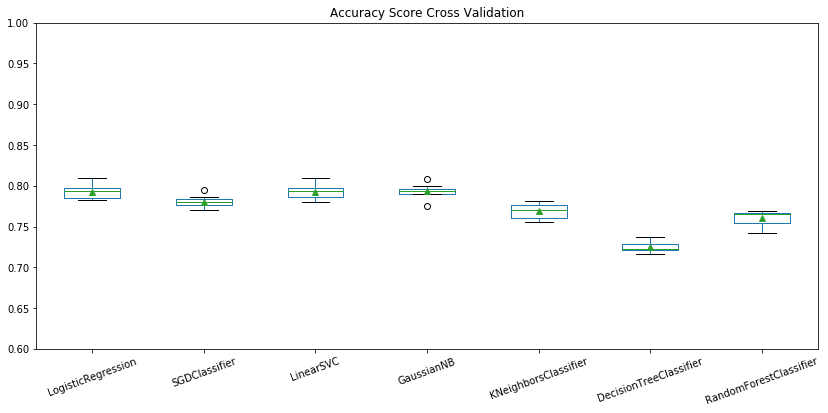

In [40]:
plot_model_cv_scores(cv_scores)

In [41]:
pd.DataFrame(cv_scores).mean()

LogisticRegression        0.792891
SGDClassifier             0.780220
LinearSVC                 0.792486
GaussianNB                0.793418
KNeighborsClassifier      0.769249
DecisionTreeClassifier    0.724921
RandomForestClassifier    0.760344
dtype: float64

## Use GridSearch to find best parameters

In [42]:
"""
estimator = RandomForestClassifier(random_state = 0, 
                               max_features = 'auto',
                               max_depth = 11,
                               min_samples_split= 6, 
                               n_estimators = 50,
                              )
param_grid = { 
    'max_depth': [7, 10, 15, 20],
    'max_features': ['auto', 'sqrt'],
    'min_samples_split': [2, 4, 6, 10],
    'n_estimators': [10, 50, 100, 150, 300]
}

CV_rfc = GridSearchCV(estimator=estimator, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_encoded, y_train)
print(CV_rfc.best_params_)
"""
#results: {'max_depth': 7, 'max_features': 'auto', 'min_samples_split': 4, 'n_estimators': 150}
print()

## Summary for Classification

- Two promissing models: 
    - Logistic Regression achieves accurary of 80% on test set
    - Support Vector Machine achieves accurary of 80% on test set
    - Random Forest with tuned parameters achieves accuracy of 80% on test set

# Predict When Employee will Quit

In [43]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.svm import SVC, LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error 

from mlencoders.weight_of_evidence_encoder import WeightOfEvidenceEncoder
from mlencoders.target_encoder import TargetEncoder

In [44]:
df.head()

,company_id,dept,seniority,salary,join_date,quit_date,quited,technical,company_2,join_year,join_month,join_day,total_months,mean_salary_dept,max_salary_dept,min_salary_dept
employee_id,,,,,,,,,,,,,,,,
13021,7,customer_service,28,89000.0,2014-03-24,2015-10-30,1,tech_no,company_id_others,2014,3,24,19,82245.424837,166000.0,17000.0
825355,7,marketing,20,183000.0,2013-04-29,2014-04-04,1,tech_no,company_id_others,2013,4,29,11,135598.042311,262000.0,30000.0
927315,4,marketing,14,101000.0,2014-10-13,NaT,0,tech_no,company_id_others,2014,10,13,360,135598.042311,262000.0,30000.0
662910,7,customer_service,20,115000.0,2012-05-14,2013-06-07,1,tech_no,company_id_others,2012,5,14,12,82245.424837,166000.0,17000.0
256971,2,data_science,23,276000.0,2011-10-17,2014-08-22,1,tech_yes,company_id_2,2011,10,17,34,206885.893417,398000.0,44000.0


In [45]:
def log_transform(df, cols):
    for col in cols:
        df[col] = np.log(df[col])
    return df

num_attribs = ['join_year', 
               'salary', 
               'join_day', 
               'seniority', 
               'join_month',
               'mean_salary_dept',
               'max_salary_dept',
               'min_salary_dept'
              ]

cat_attribs = ['dept', 'company_id']
full_pipeline, num_pipeline, cat_pipeline = make_pipeline(num_attribs, cat_attribs)

df_quited = df[df.quited == 1]
df_quited = log_transform(df_quited, num_attribs)
y = df_quited.total_months
X = df_quited[num_attribs+cat_attribs]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=11)
X_train_encoded = full_pipeline.fit_transform(X_train, y_train)
X_test_encoded = full_pipeline.transform(X_test)


model = RandomForestRegressor(random_state=11, 
                              max_depth = 11,
                              n_estimators=100)
#model = LinearSVR(C=100)
model.fit(X_train_encoded, y_train)

predictions = model.predict(X_test_encoded)
pred_train = model.predict(X_train_encoded)
baseline_preds = np.array([np.mean(y_test) for value in y_test])

In [46]:
train_rmse = np.sqrt(mean_squared_error(y_train, pred_train))
base_rmse = np.sqrt(mean_squared_error(y_test, baseline_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('\nMean Square Errors:')
print('-----------------------')
print('Mean Square Error Train: ', round(train_rmse, 2))
print('Mean Square Error Baseline: ', round(base_rmse, 2))
print('Mean Square Error Test: ', round(test_rmse, 2))
print('Percent Improvement from Baseline:', 100*(base_rmse-test_rmse)/base_rmse)
print('Sample Std:', np.std(y_train))


Mean Square Errors:
-----------------------
Mean Square Error Train:  8.09
Mean Square Error Baseline:  10.97
Mean Square Error Test:  9.8
Percent Improvement from Baseline: 10.597580629121863
Sample Std: 10.783523266427673


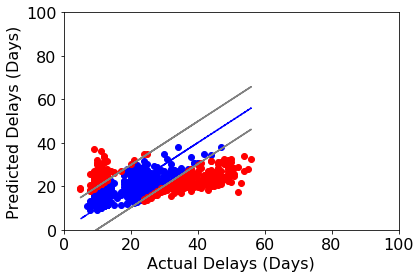

In [47]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
dyfit = test_rmse

plt.xlim(0, 100);
plt.ylim(0, 100);
plt.xlabel('Actual Delays (Days)')
plt.ylabel('Predicted Delays (Days)')


y_low = y_test - test_rmse
y_high= y_test + test_rmse

bool_mask = (predictions < y_high) & (predictions > y_low) 
y_in = predictions[bool_mask]
y_out = predictions[~bool_mask]

plt.plot(y_test[bool_mask], y_in, 'o', color='blue')
plt.plot(y_test[~bool_mask], y_out, 'o', color='red')
plt.plot(y_test, y_test, '--', color='blue')
plt.plot(y_test, y_test - dyfit, '-', color='gray')
plt.plot(y_test, y_test + dyfit, '-', color='gray')


#plt.savefig('figures/delay_days_predictions.png', dpi=200, bbox_inches='tight', pad_inches=0.2)
#plt.fill_between(y_test, y_test - dyfit, y_test + dyfit, color='gray', alpha=0.6)

# Conclusion

- Features that are important in predicting which employee will quit are
    - **The year when the employee joined** 
    - **The employee salary** 
    - **The day when the employee joined** (not very important without the year, can even be ignored.)
    - **The seniority level, i.e. the number of years of service**
    - **The month when the employee joined** (not very important without the year, can even be ignored)
 
I believe features such as the year when the employee started working as well as the salary make sense. These are all non-academic jobs, and I think people will likely quit their job early in their careers, either because they realize that the first job was not the job they wanted or because they feel like they have gained some experience and would like better opportunities. Also, if salary has been stagnant, people will likely quit. 
 
If I could add one feature, I would add I would add the age of the employee because this will determine if the employee is early in their career or a senior. 